<a href="https://colab.research.google.com/github/srt3000/CE888/blob/main/Lab_8/Lab_8_Copy_of_transfer_learning_FE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/srt3000/CE888.git

Cloning into 'CE888'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 162 (delta 79), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (162/162), 30.89 MiB | 11.59 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
# Unzip the training data
from zipfile import ZipFile
file_name = "/content/CE888/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [ ]:
import os
data_dir_list = os.listdir('/content/data')
path, dirs, files = next(os.walk("/content/data"))
file_count = len(files)
print(file_count)

0


In [ ]:
# Make new base directory
original_dataset_dir = '/content/data'
base_dir = '/content/lab8'
os.mkdir(base_dir)

FileExistsError: ignored

In [ ]:
data_dir_list = os.listdir('/content/data')
print(data_dir_list)
path, dirs, files = next(os.walk("/content/data"))

In [ ]:
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
#List the categories

categories = {}
for i in dirs:
  categories[i] = dirs.index(i)

print(categories)

{'Humans': 0, 'dogs': 1, 'horses': 2, 'cats': 3}


In [ ]:
#Specify the image size as 224, Learning rate as 1e-4

import cv2
import numpy as np
from random import shuffle
from tensorflow.keras.utils import to_categorical


IMG_SIZE = 224
LR = 1e-4

In [ ]:

from google.colab.patches import cv2_imshow

images= []       
y = []     
for dir in dirs:
    for dirname, _, filenames in os.walk(path+'/'+dir):
        for filename in filenames:
            file_path = str(path+'/'+dir+'/'+filename)
            image = cv2.resize(cv2.imread(file_path), (224, 224))
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            images.append(np.array(image))
            y.append(categories[str(dir)])
images = np.array(images)
y =np.array(to_categorical(y,num_classes=4))

In [ ]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'Humans': return 1
    elif word_label == 'cat': return 0
    elif word_label == 'horses': return 0
    elif word_label == 'cats': return 0
    

In [ ]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        # print(label)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
traval_x, test_x, traval_y, test_y = train_test_split(images, y,
                                                    stratify=y, 
                                                    test_size=0.3)

In [ ]:
train_x,validation_x,train_y,validation_y = train_test_split(traval_x,traval_y,
                                                    stratify=traval_y, 
                                                    test_size=0.3)

In [ ]:
## InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
model = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=img_input,
    input_shape=None,
    classifier_activation="softmax")
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
last_layer = model.get_layer('predictions').output
out = Dense(4, activation='softmax', name='output')(last_layer) 
model = Model(img_input, out)

for layer in model.layers[:-1]:
	layer.trainable = False

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='model.h5', save_best_only=True),
]

In [ ]:
history = model.fit(train_x, train_y,
                               batch_size=10,
                               epochs=10, 
                               validation_data=(validation_x, validation_y),
                               callbacks=my_callbacks)

Epoch 1/10
40/40 [==============================] - 11s 150ms/step - loss: 1.3843 - acc: 0.2641 - val_loss: 1.3672 - val_acc: 0.5059
Epoch 2/10
40/40 [==============================] - 4s 110ms/step - loss: 1.3595 - acc: 0.5635 - val_loss: 1.3462 - val_acc: 0.6765
Epoch 3/10
40/40 [==============================] - 4s 110ms/step - loss: 1.3348 - acc: 0.7805 - val_loss: 1.3257 - val_acc: 0.7765
Epoch 4/10
40/40 [==============================] - 4s 110ms/step - loss: 1.3189 - acc: 0.8326 - val_loss: 1.3057 - val_acc: 0.8118
Epoch 5/10
40/40 [==============================] - 4s 110ms/step - loss: 1.2933 - acc: 0.9017 - val_loss: 1.2855 - val_acc: 0.8471
Epoch 6/10
40/40 [==============================] - 4s 110ms/step - loss: 1.2764 - acc: 0.8993 - val_loss: 1.2660 - val_acc: 0.8529
Epoch 7/10
40/40 [==============================] - 4s 111ms/step - loss: 1.2498 - acc: 0.9103 - val_loss: 1.2467 - val_acc: 0.8529
Epoch 8/10
40/40 [==============================] - 4s 111ms/step - loss: 1

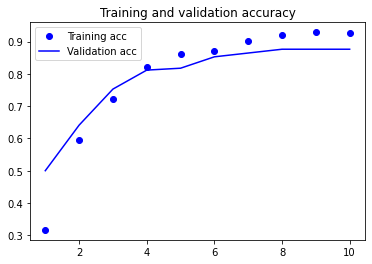

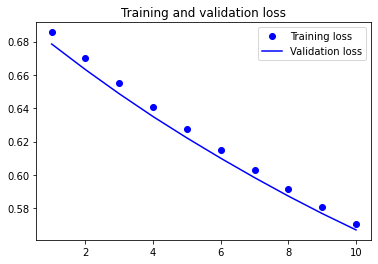

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_x)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average=None)

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9265822768211365
Val Accuracy:	 0.8764705657958984
Test Accuracy:	 0.0
Precision:	 [0. 0. 0. 0.]
Recall:		 [0. 0. 0. 0.]
F1 Score:	 [0. 0. 0. 0.]
AUC:		 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
